In [593]:
import networkx as nx
from node2vec import Node2Vec
import gzip
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import coo_matrix
import torch
import torch.nn.functional as F
from torch.nn import Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, softmax
from torch_geometric.data import Data
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import KFold
import torch.optim as optim
from torch_geometric.data import DataLoader 

In [594]:
data_path = 'NCSU-DigIC-GraphData-2023-07-25/'

In [595]:
def instances_ini(i):
    with gzip.open(data_path + 'xbar/' + str(i) + '/xbar.json.gz','rb') as f:
        design = json.loads(f.read().decode('utf-8'))
        
    instances = pd.DataFrame(design['instances'])
    nets = pd.DataFrame(design['nets'])

    conn=np.load(data_path + 'xbar/' + str(i) + '/xbar_connectivity.npz')
    A = coo_matrix((conn['data'], (conn['row'], conn['col'])), shape=conn['shape'])
    A = A.__mul__(A.T)

    def buildBST(array,start=0,finish=-1):
        if finish<0:
            finish = len(array)
        mid = (start + finish) // 2
        if mid-start==1:
            ltl=start
        else:
            ltl=buildBST(array,start,mid)
        
        if finish-mid==1:
            gtl=mid
        else:
            gtl=buildBST(array,mid,finish)
            
        return((array[mid],ltl,gtl))

    congestion_data = np.load(data_path + 'xbar/' + str(i) + '/xbar_congestion.npz')
    xbst=buildBST(congestion_data['xBoundaryList'])
    ybst=buildBST(congestion_data['yBoundaryList'])
    demand = np.zeros(shape = [instances.shape[0],])
    capacity = np.zeros(shape = [instances.shape[0],])


    def getGRCIndex(x,y,xbst,ybst):
        while (type(xbst)==tuple):
            if x < xbst[0]:
                xbst=xbst[1]
            else:
                xbst=xbst[2]
                
        while (type(ybst)==tuple):
            if y < ybst[0]:
                ybst=ybst[1]
            else:
                ybst=ybst[2]
                
        return ybst, xbst

    for k in range(instances.shape[0]):
        # print(k)
        xloc = instances.iloc[k]['xloc']; yloc = instances.iloc[k]['yloc']
        i,j=getGRCIndex(xloc,yloc,xbst,ybst)
        d = 0 
        c = 0
        for l in list(congestion_data['layerList']): 
            lyr=list(congestion_data['layerList']).index(l)
            d += congestion_data['demand'][lyr][i][j]
            c += congestion_data['capacity'][lyr][i][j]
        demand[k] = d
        capacity[k] = c
            
    instances['routing_demand'] = demand
    instances['routing_capacity'] = capacity
    instances['congestion'] = demand - capacity
    return instances, A

In [596]:
def cell_ini(i):
    with gzip.open(data_path + 'cells.json.gz','rb') as f:
        cells = json.loads(f.read().decode('utf-8'))

    cells = pd.DataFrame(cells)
    return cells

In [597]:
def norm_ohe(new_instances):
    onehotencoder = OneHotEncoder()
    orient = onehotencoder.fit_transform(new_instances[['orient']]).toarray()
    scaler = MinMaxScaler()
    new_instances = scaler.fit_transform(new_instances[['xloc', 'yloc', 'congestion', 'width', 'height']])
    return new_instances, orient

In [598]:
class GATConv(MessagePassing):
    def __init__(self, in_channels, out_channels, heads=1, concat=True, dropout=0.4):
        super(GATConv, self).__init__(node_dim=0, aggr='add')  # "Add" aggregation.
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.concat = concat
        self.dropout = dropout

        # Linear transformation matrices
        self.weight = Parameter(torch.Tensor(in_channels, heads * out_channels))
        # Attention coefficients
        self.attention = Parameter(torch.Tensor(1, heads, 2 * out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight)
        torch.nn.init.xavier_uniform_(self.attention)

    def forward(self, x, edge_index):
        x = torch.mm(x, self.weight).view(-1, self.heads, self.out_channels)
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        return self.propagate(edge_index, x=x, size=None)

    def message(self, edge_index_i, x_i, x_j, size_i):
        # Compute attention coefficients
        x = torch.cat([x_i, x_j], dim=-1)
        alpha = (x * self.attention).sum(dim=-1)
        alpha = F.leaky_relu(alpha, 0.2)
        alpha = softmax(alpha, edge_index_i, num_nodes=size_i)

        # Sample dropout for attention coefficients
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)

        return x_j * alpha.view(-1, self.heads, 1)

    def update(self, aggr_out):
        if self.concat:
            aggr_out = aggr_out.view(-1, self.heads * self.out_channels)
        else:
            aggr_out = aggr_out.mean(dim=1)
        return aggr_out

In [599]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1, dropout=0.4):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [600]:
data = []
instance_lst = []
for i in range(0, 1):
    print(i)
    instances, A = instances_ini(i+1)
    instance_lst.append(instances)
    cells = cell_ini(i+1)
    new_instances = pd.merge(instances, cells[['id', 'width', 'height']], left_on='cell', right_on='id', how='left')
    new_instances = new_instances[['xloc', 'yloc', 'congestion', 'width', 'height', 'orient']]
    new_instances, orient = norm_ohe(new_instances)
    y = new_instances[:,2]
    # remove congestion from new_instances
    node_features = np.delete(new_instances, 2, 1)
    node_features = np.concatenate((node_features, orient), axis=1)
    source_nodes, target_nodes = np.nonzero(A)
    edge_index = np.vstack((source_nodes, target_nodes))
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    #shuangxiang
    edge_index = torch.concat([edge_index, edge_index.flip[0]])
    x = torch.tensor(node_features, dtype=torch.float)
    y = torch.tensor(y, dtype=torch.float)
    data.append(Data(x=x, edge_index=edge_index, y=y))


0


KeyboardInterrupt: 

In [ ]:
data

[Data(x=[3952, 8], edge_index=[2, 141472], y=[3952]),
 Data(x=[6872, 8], edge_index=[2, 115420], y=[6872]),
 Data(x=[6913, 8], edge_index=[2, 126081], y=[6913]),
 Data(x=[7323, 8], edge_index=[2, 120929], y=[7323]),
 Data(x=[7258, 8], edge_index=[2, 121094], y=[7258]),
 Data(x=[7120, 8], edge_index=[2, 116592], y=[7120]),
 Data(x=[7879, 8], edge_index=[2, 122335], y=[7879]),
 Data(x=[7626, 8], edge_index=[2, 119388], y=[7626]),
 Data(x=[7620, 8], edge_index=[2, 119652], y=[7620]),
 Data(x=[7772, 8], edge_index=[2, 121838], y=[7772]),
 Data(x=[7814, 8], edge_index=[2, 115804], y=[7814]),
 Data(x=[6529, 8], edge_index=[2, 115553], y=[6529])]

In [ ]:
train_data = data[:1]
# val_data = data[9:12]  
test_data = data[:1]

In [ ]:
train_data

[Data(x=[3952, 8], edge_index=[2, 141472], y=[3952])]

In [ ]:
test_data

[Data(x=[3952, 8], edge_index=[2, 141472], y=[3952])]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT(in_channels=8, hidden_channels=32, out_channels=1, heads=8, dropout=0.4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

loss_values = []

# 1 for validation. 
#learning rate schu before
model.train()
for epoch in range(800):
    total_loss = 0
    for graph_data in train_data:
        graph_data = graph_data.to(device)  
        optimizer.zero_grad()
        out = model(graph_data)
        loss = F.mse_loss(out, graph_data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_data)
    print(f'Epoch {epoch+1}, Average Loss: {avg_loss}')

/var/folders/xr/wgz5b_6j3_b9vqkkp2559mvw0000gn/T/ipykernel_20915/1978372562.py:16: UserWarning: Using a target size (torch.Size([3952])) that is different to the input size (torch.Size([3952, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, graph_data.y)


Epoch 1, Average Loss: 0.38165920972824097
Epoch 2, Average Loss: 0.06832408905029297
Epoch 3, Average Loss: 0.07505068928003311
Epoch 4, Average Loss: 0.1683606654405594
Epoch 5, Average Loss: 0.17988300323486328
Epoch 6, Average Loss: 0.10002840310335159
Epoch 7, Average Loss: 0.050386443734169006
Epoch 8, Average Loss: 0.03952127322554588
Epoch 9, Average Loss: 0.058707721531391144
Epoch 10, Average Loss: 0.08794203400611877
Epoch 11, Average Loss: 0.090924933552742
Epoch 12, Average Loss: 0.08393311500549316
Epoch 13, Average Loss: 0.06453443318605423
Epoch 14, Average Loss: 0.04332535341382027
Epoch 15, Average Loss: 0.03580727428197861
Epoch 16, Average Loss: 0.04049573838710785
Epoch 17, Average Loss: 0.05772056803107262
Epoch 18, Average Loss: 0.05871806666254997
Epoch 19, Average Loss: 0.057512566447257996
Epoch 20, Average Loss: 0.04854230210185051
Epoch 21, Average Loss: 0.03969274461269379
Epoch 22, Average Loss: 0.03544890880584717
Epoch 23, Average Loss: 0.036835692822933

In [ ]:
def evaluate_model(model, data_list, device):
    model.eval()
    total_loss = 0.0
    predictions = []
    # Optionally initialize other metrics here
    with torch.no_grad():
        for graph_data in data_list:
            print(graph_data)
            graph_data = graph_data.to(device)
            out = model(graph_data)
            predictions.append(out.cpu().detach().numpy())
            loss = F.mse_loss(out, graph_data.y)  # Adjust based on your specific loss function
            total_loss += loss.item()
            # Optionally compute additional metrics here
    
    avg_loss = total_loss / len(data_list)
    # Optionally compute averages for other metrics here
    return avg_loss, predictions  # And any other metrics

# Evaluate on validation and test sets
# val_loss = evaluate_model(model, val_data, device)
test_loss, predictions = evaluate_model(model, test_data, device)
# print(f'Validation Loss: {val_loss}')
print(f'Test Loss: {test_loss}')

Data(x=[3952, 8], edge_index=[2, 141472], y=[3952])
Test Loss: 0.011140920221805573


/var/folders/xr/wgz5b_6j3_b9vqkkp2559mvw0000gn/T/ipykernel_20915/2660620629.py:12: UserWarning: Using a target size (torch.Size([3952])) that is different to the input size (torch.Size([3952, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, graph_data.y)  # Adjust based on your specific loss function


In [ ]:
predictions[0].shape

(3952, 1)

In [ ]:
data[0].y.cpu().detach().numpy().shape

(3952,)

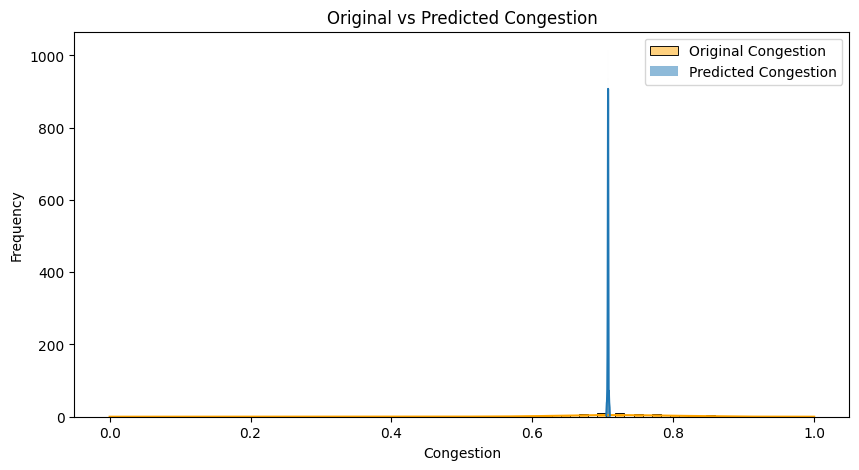

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data[0].y.cpu().detach().numpy(), kde=True, label='Original Congestion', stat="density", color='orange')
sns.histplot(predictions[0], kde=True, label='Predicted Congestion', stat="density", color='blue')
plt.xlabel('Congestion')
plt.ylabel('Frequency')
plt.title('Original vs Predicted Congestion')
plt.legend()
plt.show()

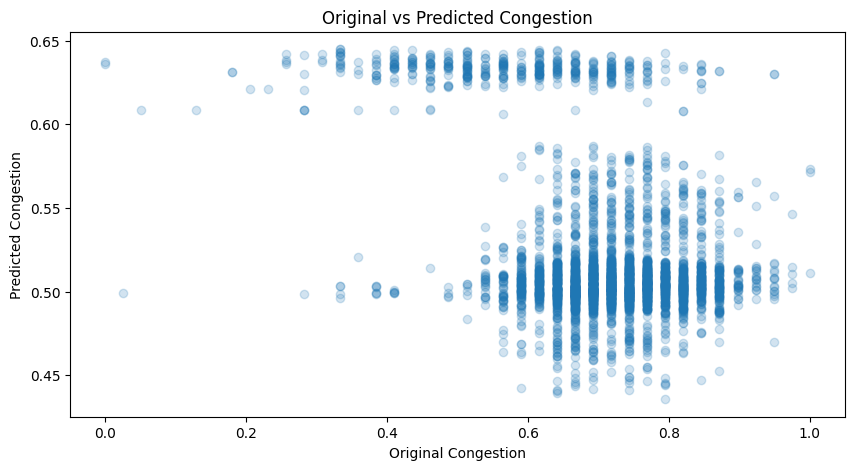

In [ ]:
# plot a scatterplot of original congestion and predicted congestion
plt.figure(figsize=(10, 5))
plt.scatter(data[0].y.cpu().detach().numpy(), predictions[0], alpha=0.2)
plt.xlabel('Original Congestion')
plt.ylabel('Predicted Congestion')
plt.title('Original vs Predicted Congestion')
plt.show()

In [ ]:
np.array(instance_lst[2][['congestion']].congestion)

array([-31., -23., -22., ..., -30., -33., -33.])

In [ ]:
congestion_scaler = MinMaxScaler()
congestion_scaler.fit_transform(instance_lst[2][['congestion']])
#prediction = out.cpu().detach().numpy()
temp = congestion_scaler.inverse_transform(predictions[0])

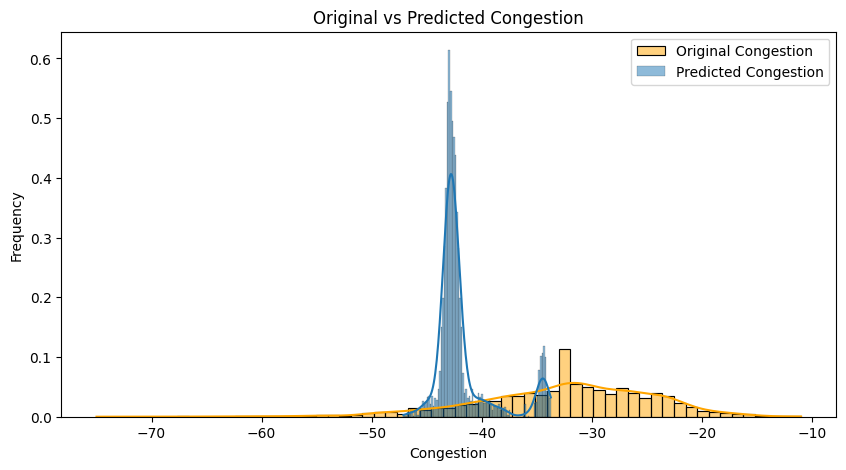

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(np.array(instance_lst[2][['congestion']].congestion), kde=True, label='Original Congestion', stat="density", color='orange')
sns.histplot(temp, kde=True, label='Predicted Congestion', stat="density", color='blue')
plt.xlabel('Congestion')
plt.ylabel('Frequency')
plt.title('Original vs Predicted Congestion')
plt.legend()
plt.show()

---

# 5-fold testing starting here

def train_and_evaluate(train_data, val_data, device):
    model = GAT(IN_CHANNELS, HIDDEN_CHANNELS, OUT_CHANNELS, HEADS, DROPOUT).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    
    # Convert list of data points to DataLoader for training
    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
    
    # Training loop
    model.train()
    for epoch in range(EPOCHS):
        total_loss = 0
        for graph_data in train_loader:
            graph_data = graph_data.to(device)
            optimizer.zero_grad()
            out = model(graph_data)
            loss = F.mse_loss(out, graph_data.y)  # Ensure your data has 'y'
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f'Train Epoch {epoch+1}, Average Loss: {avg_loss}')
    
    # Validation
    val_loss, predictions = evaluate_model(model, val_loader, device)
    print(f'Validation Loss: {val_loss}')
    return val_loss

# Update for k=5 with 5 files
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
total_val_loss = 0.0

data_indices = list(range(len(data)))  # Assuming 'data' is your dataset list

for train_idx, val_idx in kf.split(data_indices):
    print(f'Training on indices: {train_idx}, Validating on indices: {val_idx}')
    train_data = [data[i] for i in train_idx]
    val_data = [data[i] for i in val_idx]

    val_loss = train_and_evaluate(train_data, val_data, device)
    total_val_loss += val_loss

average_val_loss = total_val_loss / k
print(f'Average Validation Loss across {k} folds: {average_val_loss}')

In [ ]:
data[0].edge_index

tensor([[   0,    0,    0,  ..., 3951, 3951, 3951],
        [3951, 3950,   11,  ...,    1,    0, 3951]])

---

# Four layer starts here

In [ ]:
class DeeperGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels_1, hidden_channels_2, hidden_channels_3, out_channels, heads_1=1, heads_2=1, heads_3=1, heads_4=1, dropout=0.4):
        super(DeeperGAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels_1, heads=heads_1, dropout=dropout)
        # Adjusted for multi-head output
        self.conv2 = GATConv(hidden_channels_1 * heads_1, hidden_channels_2, heads=heads_2, dropout=dropout)
        # Further layers added
        self.conv3 = GATConv(hidden_channels_2 * heads_2, hidden_channels_3, heads=heads_3, dropout=dropout)
        self.conv4 = GATConv(hidden_channels_3 * heads_3, out_channels, heads=heads_4, concat=False, dropout=dropout)  # concat=False in the last layer to not multiply output dimensions

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # Layer 1
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        # Layer 2
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv2(x, edge_index))
        # Layer 3
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv3(x, edge_index))
        # Layer 4
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv4(x, edge_index)
        return x


In [ ]:
data

[Data(x=[3952, 8], edge_index=[2, 141472], y=[3952]),
 Data(x=[6872, 8], edge_index=[2, 115420], y=[6872]),
 Data(x=[6913, 8], edge_index=[2, 126081], y=[6913]),
 Data(x=[7323, 8], edge_index=[2, 120929], y=[7323]),
 Data(x=[7258, 8], edge_index=[2, 121094], y=[7258]),
 Data(x=[7120, 8], edge_index=[2, 116592], y=[7120]),
 Data(x=[7879, 8], edge_index=[2, 122335], y=[7879]),
 Data(x=[7626, 8], edge_index=[2, 119388], y=[7626]),
 Data(x=[7620, 8], edge_index=[2, 119652], y=[7620]),
 Data(x=[7772, 8], edge_index=[2, 121838], y=[7772]),
 Data(x=[7814, 8], edge_index=[2, 115804], y=[7814]),
 Data(x=[6529, 8], edge_index=[2, 115553], y=[6529])]

In [ ]:
train_data

[Data(x=[3952, 8], edge_index=[2, 141472], y=[3952])]

In [ ]:
test_data

[Data(x=[3952, 8], edge_index=[2, 141472], y=[3952])]

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch.optim.lr_scheduler import StepLR

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Adjusted to match DeeperGAT class
model = DeeperGAT(
    in_channels=8, 
    hidden_channels_1=32, 
    hidden_channels_2=32, 
    hidden_channels_3=32, 
    out_channels=1, 
    heads_1=4, 
    heads_2=4, 
    heads_3=4, 
    heads_4=1,  # Typically, you might not use multiple heads in the final layer
    dropout=0.4
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)  # Adjust step_size and gamma as needed

loss_values = []

model.train()
for epoch in range(1000):
    total_loss = 0
    for graph_data in train_data:
        graph_data = graph_data.to(device)
        optimizer.zero_grad()
        out = model(graph_data)
        loss = F.mse_loss(out, graph_data.y.view(-1, 1))  # Ensure the target shape matches the output
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()  # Adjust learning rate
    avg_loss = total_loss / len(train_data)
    print(f'Epoch {epoch+1}, Average Loss: {avg_loss}')


Epoch 1, Average Loss: 0.6173148155212402
Epoch 2, Average Loss: 1.9765082597732544
Epoch 3, Average Loss: 0.15189503133296967
Epoch 4, Average Loss: 0.3955332040786743
Epoch 5, Average Loss: 0.6206004023551941
Epoch 6, Average Loss: 0.35360267758369446
Epoch 7, Average Loss: 0.10769867151975632
Epoch 8, Average Loss: 0.03899866342544556
Epoch 9, Average Loss: 0.0825275108218193
Epoch 10, Average Loss: 0.12238892167806625
Epoch 11, Average Loss: 0.10374104231595993
Epoch 12, Average Loss: 0.06986508518457413
Epoch 13, Average Loss: 0.03172815591096878
Epoch 14, Average Loss: 0.06508761644363403
Epoch 15, Average Loss: 0.1000499352812767
Epoch 16, Average Loss: 0.11164341121912003
Epoch 17, Average Loss: 0.08894369751214981
Epoch 18, Average Loss: 0.04593861475586891
Epoch 19, Average Loss: 0.03576157987117767
Epoch 20, Average Loss: 0.05996546521782875
Epoch 21, Average Loss: 0.07139662653207779
Epoch 22, Average Loss: 0.06853590905666351
Epoch 23, Average Loss: 0.049045007675886154
Ep

In [ ]:
def evaluate_model(model, data_list, device):
    model.eval()
    total_loss = 0.0
    predictions = []
    with torch.no_grad():
        for graph_data in data_list:
            graph_data = graph_data.to(device)
            # Ensure targets are on the same device as the model output
            graph_data.y = graph_data.y.to(device)
            out = model(graph_data)
            # If necessary, reshape out or graph_data.y here to ensure they match
            # For example, out = out.view_as(graph_data.y) if shapes are different
            loss = F.mse_loss(out, graph_data.y.view_as(out))  # Adjusting to ensure shape compatibility
            total_loss += loss.item()
            predictions.append(out.cpu().detach().numpy())
    avg_loss = total_loss / len(data_list)
    return avg_loss, predictions

test_loss, predictions = evaluate_model(model, test_data, device)
print(f'Test Loss: {test_loss}')


Test Loss: 0.009095950983464718


In [ ]:
predictions[0].shape

(3952, 1)

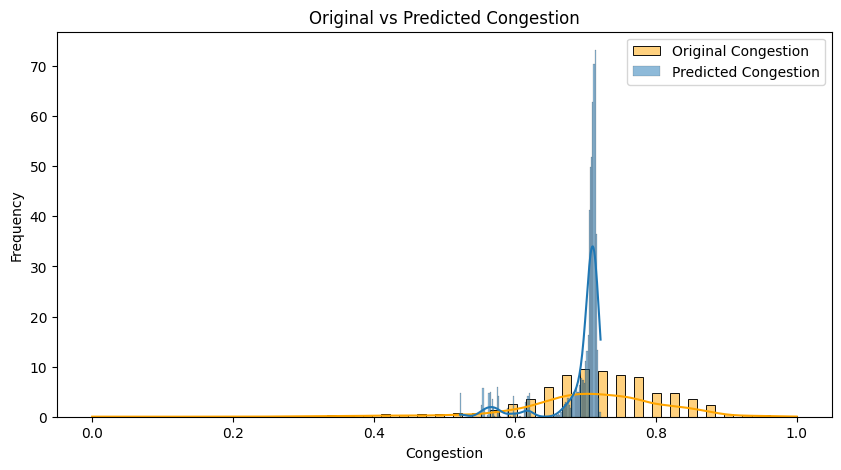

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data[0].y.cpu().detach().numpy(), kde=True, label='Original Congestion', stat="density", color='orange')
sns.histplot(predictions[0], kde=True, label='Predicted Congestion', stat="density", color='blue')
plt.xlabel('Congestion')
plt.ylabel('Frequency')
plt.title('Original vs Predicted Congestion')
plt.legend()
plt.show()

---

# Test of GCN

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.4):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = F.relu(self.conv3(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv4(x, edge_index)

        return x


In [ ]:
train_data = data[:1]
train_data

[Data(x=[3952, 8], edge_index=[2, 141472], y=[3952])]

In [ ]:
test_data = data[:1]
test_data

[Data(x=[3952, 8], edge_index=[2, 141472], y=[3952])]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the GCN model
model = GCN(
    in_channels=8, 
    hidden_channels=64, 
    out_channels=1, 
    dropout=0.4
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)  # Adjust step_size and gamma as needed

loss_values = []

model.train()
for epoch in range(2000):
    total_loss = 0
    for graph_data in train_data:
        graph_data = graph_data.to(device)
        optimizer.zero_grad()
        out = model(graph_data)
        loss = F.mse_loss(out, graph_data.y.view(-1, 1))  # Ensure the target shape matches the output
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()  # Adjust learning rate
    avg_loss = total_loss / len(train_data)
    print(f'Epoch {epoch+1}, Average Loss: {avg_loss}')

Epoch 1, Average Loss: 0.5904003977775574
Epoch 2, Average Loss: 0.35115355253219604
Epoch 3, Average Loss: 0.19939574599266052
Epoch 4, Average Loss: 0.09260035306215286
Epoch 5, Average Loss: 0.06536917388439178
Epoch 6, Average Loss: 0.1271962821483612
Epoch 7, Average Loss: 0.11793003231287003
Epoch 8, Average Loss: 0.08675910532474518
Epoch 9, Average Loss: 0.06254704296588898
Epoch 10, Average Loss: 0.055245909839868546
Epoch 11, Average Loss: 0.06101839989423752
Epoch 12, Average Loss: 0.06648214906454086
Epoch 13, Average Loss: 0.06832244992256165
Epoch 14, Average Loss: 0.06400096416473389
Epoch 15, Average Loss: 0.05897408351302147
Epoch 16, Average Loss: 0.052825380116701126
Epoch 17, Average Loss: 0.050265613943338394
Epoch 18, Average Loss: 0.05172662064433098
Epoch 19, Average Loss: 0.053668469190597534
Epoch 20, Average Loss: 0.0537869893014431
Epoch 21, Average Loss: 0.054850026965141296
Epoch 22, Average Loss: 0.0510016530752182
Epoch 23, Average Loss: 0.04880903288722

In [ ]:
def evaluate_model(model, data_list, device):
    model.eval()
    total_loss = 0.0
    predictions = []
    with torch.no_grad():
        for graph_data in data_list:
            graph_data = graph_data.to(device)
            # Ensure targets are on the same device as the model output
            graph_data.y = graph_data.y.to(device)
            out = model(graph_data)
            loss = F.mse_loss(out, graph_data.y.view_as(out)) 
            total_loss += loss.item()
            predictions.append(out.cpu().detach().numpy())
    avg_loss = total_loss / len(data_list)
    return avg_loss, predictions

test_loss, predictions = evaluate_model(model, test_data, device)
print(f'Test Loss: {test_loss}')


Test Loss: 0.015540105290710926


In [ ]:
predictions[0].shape

(3952, 1)

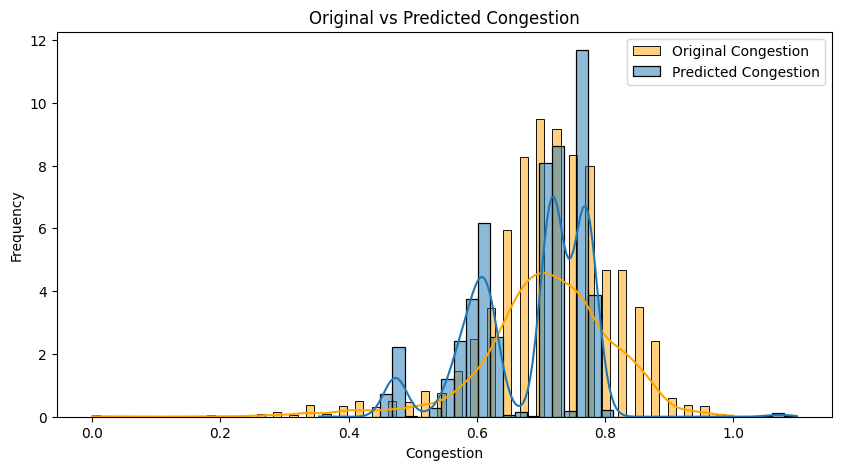

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data[0].y.cpu().detach().numpy(), kde=True, label='Original Congestion', stat="density", color='orange')
sns.histplot(predictions[0], kde=True, label='Predicted Congestion', stat="density", color='blue')
plt.xlabel('Congestion')
plt.ylabel('Frequency')
plt.title('Original vs Predicted Congestion')
plt.legend()
plt.show()

In [ ]:
predictions[0]

array([[0.58470595],
       [0.5830049 ],
       [0.5798148 ],
       ...,
       [0.6165877 ],
       [0.5444452 ],
       [0.35355794]], dtype=float32)

<AxesSubplot:ylabel='Density'>

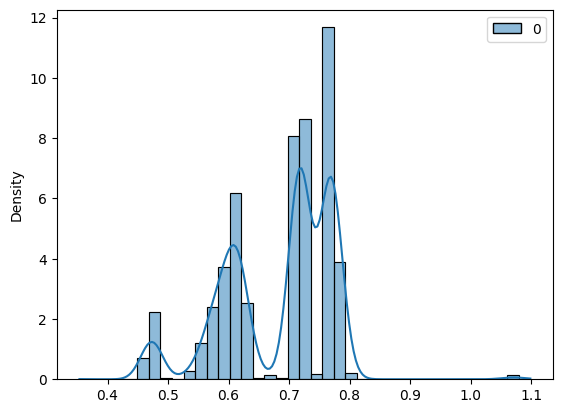

In [ ]:
sns.histplot(predictions[0], kde=True, label='Predicted Congestion', stat="density", color='blue')

In [ ]:
instance_lst[0]

,name,id,xloc,yloc,cell,orient,routing_demand,routing_capacity,congestion
0,clk_gate_out_reg/latch,0,41984,44544,23,0,20.0,28.0,-8.0
1,clk_gate_out_reg_0/latch,1,41984,47616,23,6,23.0,28.0,-5.0
2,clk_gate_out_reg_1/latch,2,44160,44544,23,0,23.0,33.0,-10.0
3,clk_gate_out_reg_2/latch,3,44160,47616,23,0,22.0,33.0,-11.0
4,clk_gate_out_reg_3/latch,4,46336,47616,23,0,21.0,23.0,-2.0
...,...,...,...,...,...,...,...,...,...
3947,U4123,3947,21888,53760,42,4,31.0,31.0,0.0
3948,U4125,3948,33664,66048,42,0,30.0,30.0,0.0
3949,U4128,3949,23296,66048,34,0,27.0,29.0,-2.0
3950,ZCTSBUF_205_132,3950,40576,44544,11,0,28.0,33.0,-5.0


In [ ]:
congestion_scaler = MinMaxScaler()
congestion_scaler.fit_transform(instance_lst[0][['congestion']])
#prediction = out.cpu().detach().numpy()
temp = congestion_scaler.inverse_transform(predictions[0])

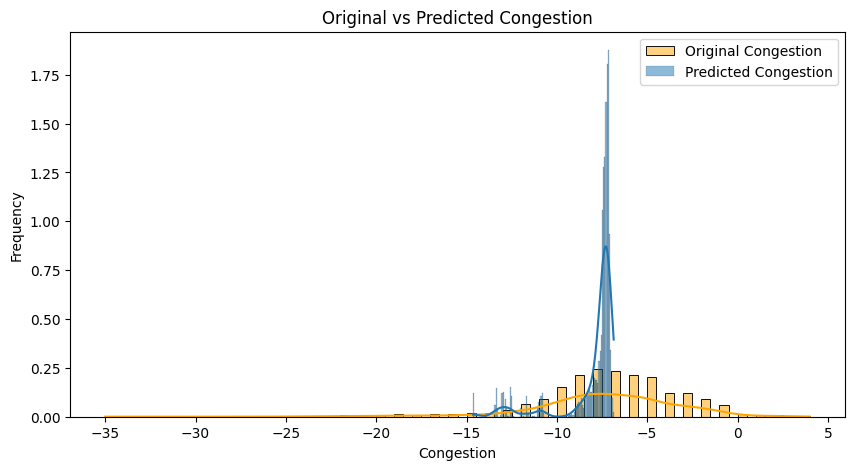

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(np.array(instance_lst[0][['congestion']].congestion), kde=True, label='Original Congestion', stat="density", color='orange')
sns.histplot(temp, kde=True, label='Predicted Congestion', stat="density", color='blue')
plt.xlabel('Congestion')
plt.ylabel('Frequency')
plt.title('Original vs Predicted Congestion')
plt.legend()
plt.show()

In [ ]:
instance_lst[0].congestion.value_counts()

-8.0     481
-7.0     464
-6.0     422
-9.0     419
-5.0     405
-10.0    302
-3.0     236
-4.0     236
-2.0     177
-11.0    176
-12.0    126
-1.0     123
-13.0     73
-15.0     41
-14.0     39
 0.0      31
-19.0     26
-17.0     25
-16.0     24
 1.0      19
-22.0     19
-20.0     18
 2.0      18
-18.0     16
-24.0      7
-21.0      5
 3.0       5
-25.0      4
-23.0      3
 4.0       3
-28.0      2
-35.0      2
-33.0      1
-30.0      1
-27.0      1
-26.0      1
-34.0      1
Name: congestion, dtype: int64

In [ ]:
instance_lst[0][['congestion']].values

array([[ -8.],
       [ -5.],
       [-10.],
       ...,
       [ -2.],
       [ -5.],
       [-13.]])

In [601]:
test = instance_lst[0][['congestion']].values
congestion_scaler = MinMaxScaler()
test1 = congestion_scaler.fit_transform(test)
test2 = congestion_scaler.inverse_transform(test1)

IndexError: list index out of range

In [602]:
test

array([[ -8.],
       [ -5.],
       [-10.],
       ...,
       [ -2.],
       [ -5.],
       [-13.]])

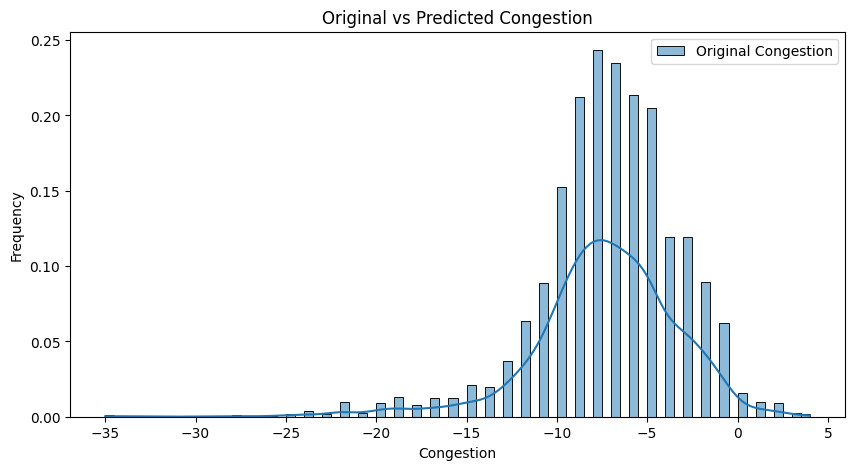

In [613]:
plt.figure(figsize=(10, 5))
sns.histplot(test, kde=True, label='Original Congestion', stat="density", color='orange')
# sns.histplot(test2, kde=True, label='Predicted Congestion', stat="density", color='orange')
plt.xlabel('Congestion')
plt.ylabel('Frequency')
plt.title('Original vs Predicted Congestion')
plt.legend()
plt.show()